In [1]:
# load image data
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm

In [72]:
# Import tools and libraries

import os, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import sklearn
import pandas as pd
import string
from collections import Counter

import tensorflow as tf
import tensorflow.keras.backend as K
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import initializers
from keras.callbacks import History

import cv2
import imageio # use imread function to read the image
from PIL import Image
from sklearn.metrics import classification_report

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # visualization


np.random.seed(42)
tf.random.set_seed(42)

### GTSRB - German Traffic Sign Recognition Benchmark Dataset

### Data source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train.csv

### Open the label file (labels-map-proj-v3.txt) and get the lable lines

### Get Labels Data

In [51]:
#load the labels from the test Excel file in the sign_data folder

classid_path = "sign_data"

# open the train Excel file in the sign_data folder
train_classid = pd.read_csv(os.path.join(classid_path, "Train.csv"))

# open the test Excel file in the sign_data folder
test_classid = pd.read_csv(os.path.join(test_classid_path, "Test.csv"))

# define a function to get the class id and path of the train images into a list

def get_id_path (filename):
    image_path = []
    class_id = []
    for i in tqdm(range(len(filename))):
        image_path.append(os.path.join(classid_path, filename.iloc[i, 7]))
        class_id.append(filename.iloc[i, 6])
    return image_path, class_id

train_image_path, train_class_id = get_id_path(train_classid)
test_image_path, test_class_id = get_id_path(test_classid)
        
print("Total number of train images: ", len(train_image_path))
print("Total number of train class ids: ", len(train_class_id))   
print("Total number of test images: ", len(test_image_path))
print("Total number of test class ids: ", len(test_class_id))

print(train_image_path[:2], train_class_id[:2])


100%|██████████| 12630/12630 [00:00<00:00, 19767.31it/s]

Total number of train images:  39209
Total number of train class ids:  39209
Total number of test images:  12630
Total number of test class ids:  12630
['sign_data/Train/20/00020_00000_00000.png', 'sign_data/Train/20/00020_00000_00001.png'] [20, 20]


In [39]:
# check for duplicates

import collections
duplicate_list_train = [item for item, count in collections.Counter(train_image_path).items() if count > 1]
print("Duplicate size:", len(duplicate_list_train))

duplicate_list_test = [item for item, count in collections.Counter(test_image_path).items() if count > 1]
print("Duplicate size:", len(duplicate_list_test))
     



Duplicate size: 0
Duplicate size: 0


In [59]:
# select one sample of each class id in the train_class_id list and find the corresponding image path

unique_class_id = np.unique(train_class_id)
print("Unique class id: ", unique_class_id)
unique_class_id_path = []
for i in tqdm(range(len(unique_class_id))):
    for j in range(len(train_class_id)):
        if unique_class_id[i] == train_class_id[j]:
            unique_class_id_path.append(train_image_path[j])
            break
print("Total number of unique class id: ", len(unique_class_id_path))  




Unique class id:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


100%|██████████| 43/43 [00:00<00:00, 238.63it/s]

Total number of unique class id:  43


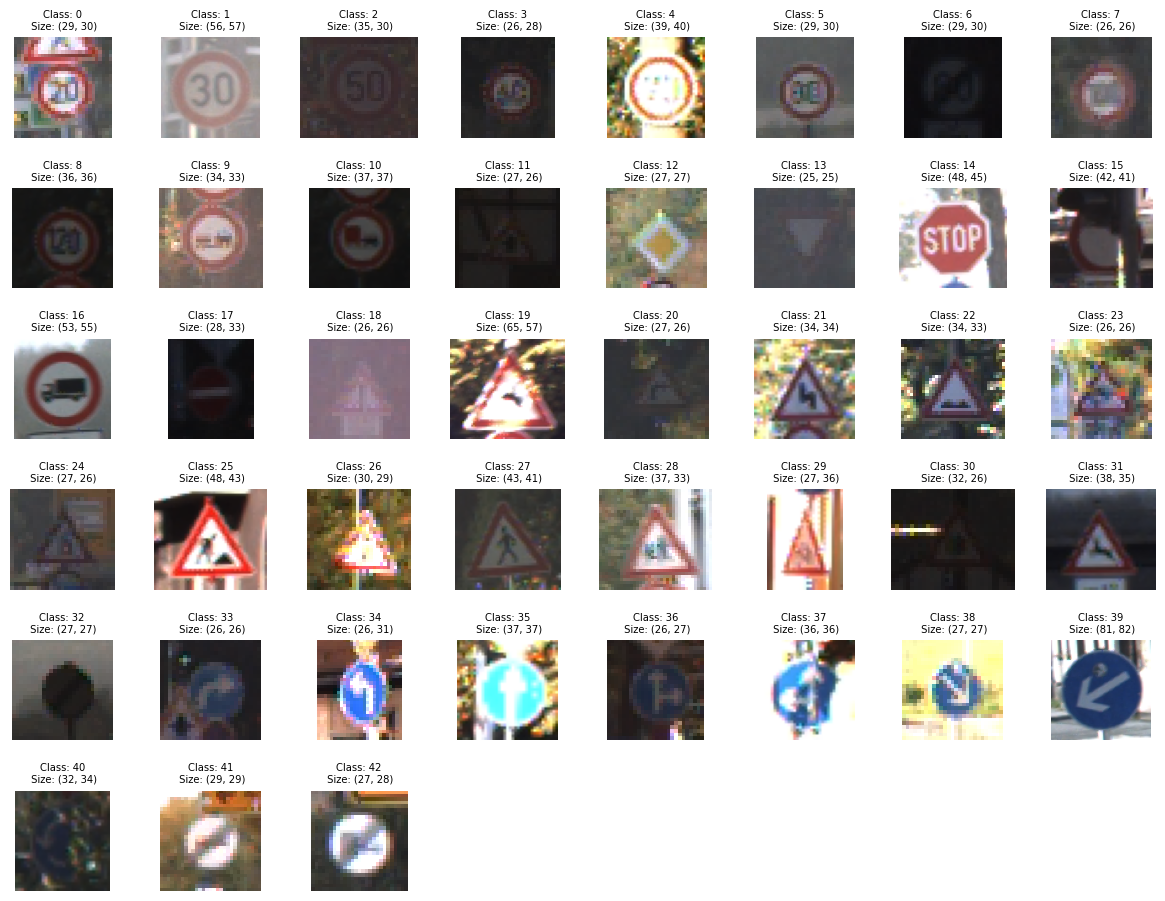

In [68]:
#show the images of the unique class id
plt.figure(figsize=(15, 15))
for i in range(len(unique_class_id_path)):
    plt.subplot(8, 8, i+1)
    plt.imshow(Image.open(unique_class_id_path[i]))
    plt.title(unique_class_id[i])
    plt.axis("off")
    plt.subplots_adjust(hspace = 0.5)
    #split the title into two lines
    plt.title("Class: "+ str(unique_class_id[i]) + "\n Size: "+ str(Image.open(unique_class_id_path[i]).size))

    #change the fond size of the title
    plt.rcParams.update({'font.size': 6})


plt.show()


Text(0.5, 1.0, 'Distribution of Test Classes')

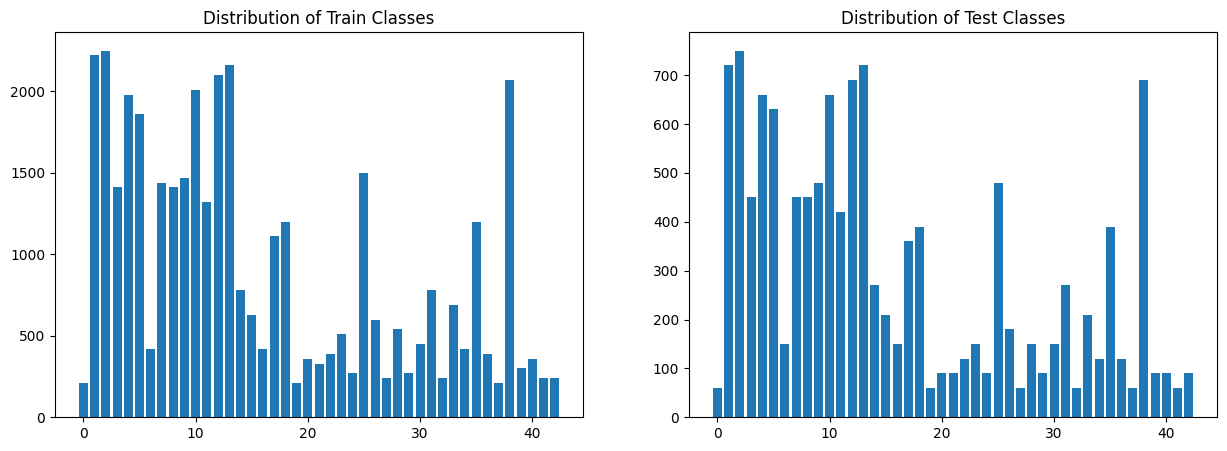

In [33]:
# show the train and test class ids in two separate bar graphs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(train_class_id), np.bincount(train_class_id))
plt.title("Distribution of Train Classes")
plt.subplot(1, 2, 2)
plt.bar(np.unique(test_class_id), np.bincount(test_class_id))
plt.title("Distribution of Test Classes")



In [69]:
# get the minimum and maximum size of the images in the train and test data
train_image_size = []
for i in tqdm(range(len(train_image_path))):
    train_image_size.append(Image.open(train_image_path[i]).size)
print("Minimum size of train image: ", min(train_image_size))
print("Maximum size of train image: ", max(train_image_size))

test_image_size = []
for i in tqdm(range(len(test_image_path))):
    test_image_size.append(Image.open(test_image_path[i]).size)
print("Minimum size of test image: ", min(test_image_size))
print("Maximum size of test image: ", max(test_image_size))


100%|██████████| 39209/39209 [05:05<00:00, 128.34it/s]


Minimum size of train image:  (25, 25)
Maximum size of train image:  (243, 225)


100%|██████████| 12630/12630 [02:36<00:00, 80.75it/s]

Minimum size of test image:  (25, 25)
Maximum size of test image:  (266, 232)


### Data Preprocessing



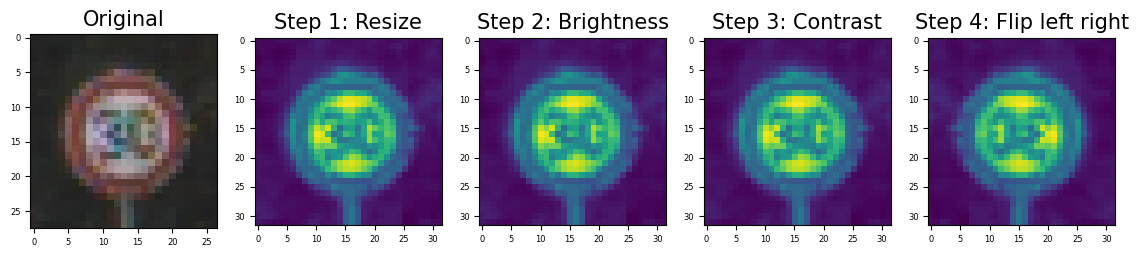

In [84]:
# use one example to explore the image transformation and augmentation techniques
#################################################################################

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = load_img(train_image_path[900])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title('Original', size=15);

#test the image transformation
img_io = tf.io.read_file(train_image_path[900])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 32))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

### Define a distoration free function to standardize the image size with padding

In [73]:
# Resizing images without distortion

# resize the images to 32x32
img_size = (32, 32)

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # add the same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],
                                    [pad_width_left, pad_width_right],
                                    [0, 0],],)
    
    # To improve the model accuracy, use the following techniques to 
    # adjust brightness, adjust contrast, transpose and flip the images
    image = tf.image.adjust_brightness(image, 0.3)
    image = tf.image.adjust_contrast(image, contrast_factor=3)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [74]:
# use the distortion_free_resize function to resize the train images

train_images_new = []
for i in tqdm(range(len(train_image_path))):
    image = tf.keras.preprocessing.image.load_img(train_image_path[i])
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = distortion_free_resize(image, img_size)
    train_images.append(image)
train_images_np = np.array(train_images_new)
print("Shape of train images: ", train_images_np.shape)

 18%|█▊        | 7051/39209 [01:18<07:13, 74.16it/s] 

In [ ]:
# use the distortion_free_resize function to resize the test images

test_images_new = []
for i in tqdm(range(len(test_image_path))):
    image = tf.keras.preprocessing.image.load_img(test_image_path[i])
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = distortion_free_resize(image, img_size)
    test_images_new.append(image)
test_images_np = np.array(test_images_new)
print("Shape of test images: ", test_images_np.shape)